In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mapcalc import Map
import matplotlib.image as mpimg
from scipy.ndimage import zoom
from mapcalc import Map
from queue import PriorityQueue

In [2]:
map_location = "map_source/map_source.csv"
map_expand_location = "map_source/map_expand_sharp.csv"

In [3]:
base_org_map = Map(map_location)
base_exp_map = Map(map_expand_location)
org_map = base_org_map.load()
exp_map = base_exp_map.load()

In [4]:
start_loc = [200, 150, 0]
destn_loc = [1220, 1100, 0]

In [7]:
def a_star_search(start, goal, grid):
    # Heuristic function: Manhattan distance
    def heuristic(a, b):
        return abs(a[0] - b[0]) + abs(a[1] - b[1])

    # Directions for moving up, down, left, right
    directions = [(0, 1), (0, -1), (-1, 0), (1, 0)]

    # Initialize both the open and closed sets
    open_set = PriorityQueue()
    open_set.put((0, start))
    came_from = {}
    g_score = {position: float('inf') for position in np.ndindex(grid.shape)}
    g_score[start] = 0
    f_score = {position: float('inf') for position in np.ndindex(grid.shape)}
    f_score[start] = heuristic(start, goal)

    while not open_set.empty():
        _, current = open_set.get()

        if current == goal:
            # Reconstruct path
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start)
            return path[::-1]  # Return reversed path

        for direction in directions:
            neighbor = (current[0] + direction[0], current[1] + direction[1])

            # Check if within bounds and not an obstacle
            if 0 <= neighbor[0] < grid.shape[0] and 0 <= neighbor[1] < grid.shape[1] and grid[neighbor] == 0:
                tentative_g_score = g_score[current] + 1  # Assume cost between nodes is 1

                if tentative_g_score < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = g_score[neighbor] + heuristic(neighbor, goal)
                    open_set.put((f_score[neighbor], neighbor))

    return None  # Path not found

In [6]:
def heuristic(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def a_star_search_np(start, goal, grid):
    directions = [(0, 1), (0, -1), (-1, 0), (1, 0)]
    open_set = PriorityQueue()
    open_set.put((0, start))
    came_from = {}
    
    g_score = np.full(grid.shape, float('inf'))
    g_score[start] = 0
    
    f_score = np.full(grid.shape, float('inf'))
    f_score[start] = heuristic(start, goal)
    
    while not open_set.empty():
        _, current = open_set.get()

        if current == goal:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start)
            return path[::-1]

        for direction in directions:
            neighbor = (current[0] + direction[0], current[1] + direction[1])

            if 0 <= neighbor[0] < grid.shape[0] and 0 <= neighbor[1] < grid.shape[1] and grid[neighbor] == 0:
                tentative_g_score = g_score[current] + 1

                if tentative_g_score < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                    open_set.put((f_score[neighbor], neighbor))

    return None

def flip_tuples(tuple_list):
    return [(t[1], t[0]) for t in tuple_list]

In [7]:
astar_path = a_star_search_np(
    (start_loc[1], start_loc[0]), 
    (destn_loc[1], destn_loc[0]), 
    exp_map)

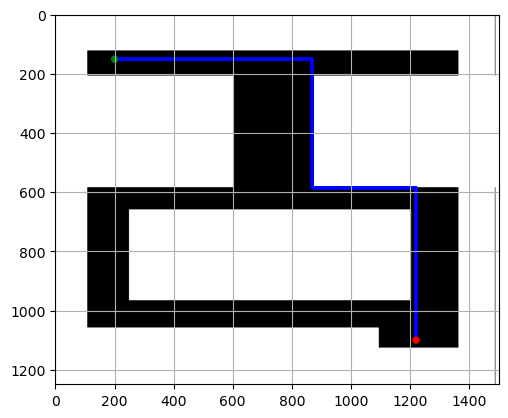

In [29]:
start_marker = plt.Circle((start_loc[0], start_loc[1]), 10, color="g")
destn_marker = plt.Circle((destn_loc[0], destn_loc[1]), 10, color="r")
for path_marker in flip_tuples(astar_path):
    plt.gca().add_patch(plt.Circle(path_marker, 3, color="b"))
plt.gca().add_patch(start_marker)
plt.gca().add_patch(destn_marker)
plt.grid()
plt.imshow(exp_map, cmap="grey")

In [32]:
def path_to_commands_optimized(path):
    # Helper function to calculate turn direction and angle
    def calculate_turn(current_direction, new_direction):
        # Mapping of direction changes to turn angles
        turn_mapping = {
            ('up', 'right'): ('turn', 90),
            ('right', 'down'): ('turn', 90),
            ('down', 'left'): ('turn', 90),
            ('left', 'up'): ('turn', 90),
            ('up', 'left'): ('turn', -90),
            ('left', 'down'): ('turn', -90),
            ('down', 'right'): ('turn', -90),
            ('right', 'up'): ('turn', -90),
        }
        return turn_mapping.get((current_direction, new_direction), ('stop', 0))

    directions = {'up': (-1, 0), 'down': (1, 0), 'left': (0, -1), 'right': (0, 1)}
    direction_keys = {v: k for k, v in directions.items()}  # Reverse mapping for deltas to direction keys
    current_direction = 'up'
    
    commands = []
    move_count = 0  # Initialize move count

    for i in range(len(path) - 1):
        current_point = path[i]
        next_point = path[i + 1]
        delta = (next_point[0] - current_point[0], next_point[1] - current_point[1])
        new_direction = direction_keys.get(delta)

        # If the direction changes, process the previous movement first
        if new_direction != current_direction:
            if move_count > 0:
                commands.append(('forward', move_count))
                move_count = 0  # Reset move count

            turn_command, turn_angle = calculate_turn(current_direction, new_direction)
            commands.append((turn_command, turn_angle))
            current_direction = new_direction

        move_count += 1  # Increment move count for each step in the same direction

    # Add the last movement command if any
    if move_count > 0:
        commands.append(('forward', move_count))

    return commands


In [66]:
commands = path_to_commands_optimized(astarboi_np)
for com in commands:
    print(com)

('turn', 90)
('forward', 669)
('turn', 90)
('forward', 435)
('turn', -90)
('forward', 351)
('turn', 90)
('forward', 515)


In [ ]:
import smbus

In [ ]:
class I2CDevice:
    def __init__(self, address=0x08, bus_number=1):
        self.address = address
        self.bus = smbus.SMBus(bus_number)

    def send_integers(self, integers):
        bytes_to_send = []
        for integer in integers:
            bytes_to_send.append(integer)

        try:
            self.bus.write_i2c_block_data(self.address, 0x00, bytes_to_send)
            print("Successfully sent 4 integers.")
            return True
        except IOError as e:
            print(f"Failed to send data: {e}")
            return False

    def close(self):
        self.bus.close()

In [73]:
class AMR:
    def __init__(self) -> None:
        self.i2c  = None
        
        self.deg_per_step = 1.8
        self.step_per_rotation = 360 / self.deg_per_step
        

        self.wheel_dia = 59.52 # mm
        self.wheel_r = self.wheel_dia / 2
        self.wheelbase = 98.6 # mm
        self.track = 169.5 # mm

        self.dist_per_step = np.pi * self.wheel_dia * self.deg_per_step / 360 # mm
        

        self.v = round(self.speed_w * self.wheel_r, 1) # mm/s
        self.two_pi = 2 * np.pi

        self.i2c_channel : I2CDevice

    def initialize_communication(self, i2c_comm: I2CDevice):
        self.i2c_channel = i2c_comm

    def turn(self, angle):
        return
    
    def forward(self, distance, duration):
        return
    
    def forward_step_control(self, distance):
        return
    
    def reverse(self, distance, duration):
        return
    
    def sps_to_w(self, sps):
        return sps/200 * self.two_pi # steps per second to radians/second

    def analyze_commands(self, commands):
        self.commands = commands
        self.total_distance = 0
        self.parsed_command = []
        for command in commands:
            print(command)
            rigorous_command = list(command)
            if command[0] == "turn":
                rigorous_command.append(1)
            elif command[0] == "forward":
                self.total_distance += command[1]
                fwd_duration = command[1] / self.v
                rigorous_command.append(fwd_duration)
        print(f"Total distance: {self.total_distance}mm")

    def order_steps(self, order):
        return

In [77]:
igpamr = AMR()
igpamr.analyze_commands(commands)
igpamr.turn(90)

('turn', 90)
('forward', 669)
('turn', 90)
('forward', 435)
('turn', -90)
('forward', 351)
('turn', 90)
('forward', 515)
Total distance: 1970mm


0.8899319556451611